# InsideAirbnb Twin Cities 

Data source: http://insideairbnb.com/index.html

## Load data

In [0]:
%%writefile airbnbloader.py
from collections import OrderedDict
import pandas as pd
from datetime import datetime
import numpy as np


def load(date='2019-06-02', location='united-states/mn/twin-cities-msa'):

    filename = (
        'http://data.insideairbnb.com/{}/{}/data/listings.csv.gz'.format(
            location, date))

    data = pd.read_csv(filename)

    data.price = data.price.apply(lambda x: float(x[1:].replace(',', '')))

    weekday = data.last_review.dropna().apply(
      lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%A'))
    weekday.name = 'last_review_weekday'
    data = data.join(weekday)

    days_since_last_review = data.last_review.dropna().apply(
        lambda x: (datetime.strptime(date, '%Y-%m-%d')
                   - datetime.strptime(x, '%Y-%m-%d')).days)
    days_since_last_review.name = 'days_since_last_review'
    data = data.join(days_since_last_review)

    features = data[[
        'price',
        'latitude',
        'longitude',
        'room_type',
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'minimum_nights',
        'days_since_last_review',
        'number_of_reviews',
        'reviews_per_month',
        'calculated_host_listings_count',
        'availability_30',
        'availability_365'
        ]]

    features.dropna(inplace=True)
    features = features[features.availability_365 != 0]
    features = features[features.availability_365 != 365]

    onehot_room_type = pd.get_dummies(features['room_type'])

    onehot_room_type.drop(['Private room'], axis=1, inplace=True)

    features = pd.concat([features, onehot_room_type], axis=1)

    targets = features['price'].apply(lambda x: np.log(x+1))

    features.drop(['price', 'room_type'], axis=1, inplace=True)

    return features, targets, data


def all_value_counts(data, n=5):

    return OrderedDict(
        (field,
         dict(n=len(set(data[field])),
              top=list(zip(
                  data[field].value_counts().head(n).index,
                  data[field].value_counts().head(n).values))))
        for field in data.columns)

Overwriting airbnbloader.py


In [0]:
import importlib
import warnings
import airbnbloader

warnings.filterwarnings('ignore')
importlib.reload(airbnbloader)

# Some dates that are available for
# location='united-states/mn/twin-cities-msa':
# last June: date='2019-06-02'
# last January: date='2020-01-04'
# most recent: date='2020-04-14'

features, targets, data = airbnbloader.load(
    location='united-states/mn/twin-cities-msa',
    date='2019-06-02'
)

features.shape, targets.shape, data.shape

((2951, 15), (2951,), (6607, 108))

Split to train and test data sets.

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,
    targets,
    test_size=0.25,
    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2213, 15), (738, 15), (2213,), (738,))

Uncomment to take a peek at the data.

In [0]:
import pandas as pd

# pd.options.display.max_rows = 200
# pd.DataFrame(data.isna().mean().sort_values(ascending=False),
#              columns = ['NA rate'])

In [0]:
# airbnbloader.all_value_counts(features)

## Map listings

In [0]:
%%writefile mapairbnb.py
import plotly.graph_objects as go


def plot(data, features, color_by, color_title, zoom=10, hover=True,
         center=dict(lat=44.981944, lon=-93.269167)):

    data_ = data.loc[features.index]

    if hover:
        text = [
            '{}  <br> ${}'.format(data_.name[i], data_.price[i])
            + '<br>Number of reviews: {}<br>'.format(
                data_.number_of_reviews[i])
            + ' <a href="{}">link</a>'.format(
                data_.listing_url[i])
            + '<br>Availability: {}'.format(data_.availability_365[i])
            + '<br>Days since last review: {}'.format(
                features.days_since_last_review[i])
            + '<br>Accommodates: {}'.format(features.accommodates[i])
            for i in data_.index]
    else:
        text = ''

    fig = go.Figure(go.Scattermapbox(
        lat=features.latitude,
        lon=features.longitude,
        mode='markers',
        text=text,
        hoverinfo='text',
        marker=dict(color=color_by, colorscale='rainbow',
                    colorbar=dict(title=color_title), size=9),
        ))

    fig.update_layout(
        hovermode='x',
        hoverdistance=20,
        mapbox_style='white-bg',
        autosize=True,
        mapbox_layers=[{
            'below': 'traces', 'sourcetype': 'raster',
            'source': ['https://basemap.nationalmap.gov/arcgis/rest/services/'
                       + 'USGSImageryOnly/MapServer/tile/{z}/{y}/{x}']}],
        mapbox=dict(bearing=0, center=center, pitch=0, zoom=zoom),
        )

    fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

    return fig

Overwriting mapairbnb.py


In [0]:
import mapairbnb

importlib.reload(mapairbnb)

mapairbnb.plot(data, features, color_by=targets, color_title='Log price')

## OLS Regression

In [0]:
import statsmodels.api as sm
import pandas as pd

X_train_with_const = sm.add_constant(
    pd.DataFrame(X_train, columns=features.columns))
X_test_with_const = sm.add_constant(
    pd.DataFrame(X_test, columns=features.columns))

results = sm.OLS(y_train, X_train_with_const).fit(cov_type='HC0')

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     225.5
Date:                Mon, 18 May 2020   Prob (F-statistic):               0.00
Time:                        12:23:01   Log-Likelihood:                -1952.4
No. Observations:                2213   AIC:                             3937.
Df Residuals:                    2197   BIC:                             4028.
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

## Map overpricing

Since reviews indicate lower prices relative to the value of the listing we need to fix the review variables on some constant values when producing valuations. We replace every reviews-related variable with its median.

In [0]:
features.median()

latitude                           44.95976
longitude                         -93.26204
accommodates                        4.00000
bathrooms                           1.00000
bedrooms                            1.00000
beds                                2.00000
minimum_nights                      2.00000
days_since_last_review             19.00000
number_of_reviews                  18.00000
reviews_per_month                   1.39000
calculated_host_listings_count      2.00000
availability_30                    10.00000
availability_365                  173.00000
Entire home/apt                     1.00000
Shared room                         0.00000
dtype: float64

In [0]:
%%writefile fixcolumns.py
import numpy as np
import pandas as pd


def fix(data, fix_columns, fix_on):

    all_fixed = pd.DataFrame(
        np.tile(fix_on, (len(data), 1)),
        columns=data.columns)

    all_fixed.index = data.index

    fixed_data = data.copy()

    fixed_data[fix_columns] = all_fixed[fix_columns]

    return fixed_data


Overwriting fixcolumns.py


In [0]:
import fixcolumns
importlib.reload(fixcolumns)

fix_reviews = fixcolumns.fix(
    data=features,
    fix_columns=[
        'days_since_last_review',
        'number_of_reviews',
        'reviews_per_month'],
    fix_on=features.median().values
    )

fix_reviews.head()

latitude  longitude  ...  Entire home/apt  Shared room
0  45.00886  -93.23407  ...                1            0
1  44.94566  -93.35721  ...                0            0
2  44.91878  -93.23038  ...                0            0
3  44.92053  -93.35049  ...                1            0
7  44.92136  -93.22873  ...                0            0

[5 rows x 15 columns]

Now we can use the review-constant listings to estimate the "right" price for listings and compare that to what it is listed for. 

In [0]:
ols_predicted = results.predict(
    sm.add_constant(fix_reviews, has_constant='add'))
overpriced = targets-ols_predicted
mapairbnb.plot(
    data, features, color_by=overpriced, color_title='Diff log price')

## Location, location, location!

To see the effect of location we need to hold everything else fixed. One approach is to pick the median value for everything other than location and use that to make predictions.

In [0]:
location_only = fixcolumns.fix(
    data=features,
    fix_columns=features.columns[2:],
    fix_on=features.describe().loc['50%'].values
    )

location_only.head()

latitude  longitude  ...  Entire home/apt  Shared room
0  45.00886  -93.23407  ...              1.0          0.0
1  44.94566  -93.35721  ...              1.0          0.0
2  44.91878  -93.23038  ...              1.0          0.0
3  44.92053  -93.35049  ...              1.0          0.0
7  44.92136  -93.22873  ...              1.0          0.0

[5 rows x 15 columns]

In [0]:
import numpy as np

location_predicted = results.predict(
    sm.add_constant(location_only, has_constant='add'))

mapairbnb.plot(data, features, color_by=np.exp(location_predicted),
               color_title='Predicted price', zoom=7, hover=False)

Faliure: a linear model can only generate linear maps, but location isn't linear.

# TensorFlow 2

Coding with TensorFlow is very similar to coding with Numpy, you just have to use TensorFlow functions instead of Numpy functions. The difference is that TensorFlow functions enable symbolic calculations, like taking derivatives. 


## Example: calculating $R^2$


Let's write a function calculating $R^2$ in TensorFlow. Recall that 

$$R^2=1-\frac{\Sigma (y-\hat{y})^2}{\Sigma (y-\bar{y})^2}$$


TensorFlow doesn't provide an $R^2$ metric. There are probably two reasons for that:

1. $R^2$ computed on each batch is a downward biased estimate of whole epoch $R^2$, because of the division by batch variance.
2. Even correcting for the bias, the average $R^2$ of batches will not be exactly the $R^2$ of the whole epoch.

We can somewhat adjust for the first issue with the usual small sample bias correction, and we can live with the second issue.

$$\tilde{R}^2=1-\frac{\Sigma (y-\hat{y})^2}{\frac{n}{n-1}\Sigma (y-\bar{y})^2}$$



In [0]:
%%writefile tf_r2.py
import tensorflow as tf


def R_squared(y_true, y_pred):

    # TensorFlow uses 'float32' as the default type and often raises an error
    # when you mix 'float32' and 'float64' in calculations. Since 'float64' is
    # the Python and Numpy default, this happens a lot. Casting everything to
    # 'float32' is your best option.

    y_true = tf.cast(y_true, 'float32')
    y_pred = tf.cast(y_pred, 'float32')

    residual_var = tf.reduce_sum(tf.square(y_true - y_pred))
    total_var = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))

    # Adjust for small batch bias
    n = tf.cast(tf.size(y_true), 'float32')
    total_var *= n/(n-1)

    return (1.0 - residual_var/total_var)

Writing tf_r2.py


Tensorflow functions produce tensors which are only computed when you call `.numpy()` on them.

In [0]:
import numpy as np
import tf_r2

importlib.reload(tf_r2)

OLS_r2 = dict(
    Train=tf_r2.R_squared(
        y_train,
        results.predict(X_train_with_const)
        ).numpy(),
    Test=tf_r2.R_squared(
        y_test,
        results.predict(X_test_with_const)
        ).numpy()
    )

pd.DataFrame(pd.Series(OLS_r2), columns=['OLS R2']).transpose()

Train      Test
OLS R2  0.601956  0.540067

## The three APIs

Here is the same simple network implemented using the three APIs.

In [0]:
%%writefile simple_dnn.py

import tensorflow.keras as keras
from tf_r2 import R_squared

# The sequencial API: create one layer at a time and add it to the model.
# We don't have to provide the shape of the input, but if we don't the
# construction of the model will be delayed until the first call to `fit()`


def build_model_sequential(
        input_shape=None,
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2,
        optimizer=keras.optimizers.SGD(0.025)):

    model = keras.Sequential()
    for i in range(n_hidden):
        if i == 0 and input_shape:
            model.add(keras.layers.Dense(width,
                                         activation=activation,
                                         input_shape=input_shape))
        else:
            model.add(keras.layers.Dense(width, activation=activation))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1))

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=[R_squared])

    return model

# The functional API: create layers and apply them, all before input.
# We have to provide the shape of the input to `keras.Input`.


def build_model_functional(
        input_shape,
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2,
        optimizer=keras.optimizers.SGD(0.025)):

    inputs = keras.Input(shape=input_shape)
    x = inputs
    for i in range(n_hidden):
        x = keras.layers.Dense(width, activation=activation)(x)
        x = keras.layers.Dropout(dropout)(x)
    outputs = keras.layers.Dense(1)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=[R_squared])

    return model

# The subclassing API: create layers and store them, apply only on input.
# We don't need to provide the shape of the input.


def build_model_subclassing(
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2,
        optimizer=keras.optimizers.SGD(0.025)):

    class MyModel(keras.Model):
        def __init__(self):
            super(MyModel, self).__init__()
            self.dense = []
            self.dropout = []
            for i in range(n_hidden):
                self.dense.append(
                    keras.layers.Dense(
                        width, activation=activation))
                self.dropout.append(keras.layers.Dropout(dropout))
            self.out = keras.layers.Dense(1)

        def call(self, x):
            for i in range(n_hidden):
                x = self.dense[i](x)
                x = self.dropout[i](x)
            return self.out(x)

    model = MyModel()

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=[R_squared])

    return model

# Training is the same for all


def train_model(model, X_train, y_train, X_test, y_test):

    batch_size = 32

    # Trim data to whole multiple of batch size so that R2 doesn't encounter
    # very small batches at the end of an epoch
    X_train = X_train[:-(len(X_train) % batch_size)]
    y_train = y_train[:-(len(y_train) % batch_size)]
    X_test = X_test[:-(len(X_test) % batch_size)]
    y_test = y_test[:-(len(y_test) % batch_size)]

    early_stopping = keras.callbacks.EarlyStopping(
        patience=30,
        restore_best_weights=True)

    history = model.fit(
        X_train,
        y_train,
        batch_size=batch_size,
        epochs=1000,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping]
    )

    return history


Writing simple_dnn.py


You can't ask for `summary()` when not providing input_shape as the layers only 
get built on the first input. There used to be a `build(input_shape)` method, but it has been deprecated.

In [0]:
import simple_dnn

importlib.reload(simple_dnn)

simple_dnn.build_model_sequential(X_train.shape[1:]).summary()
simple_dnn.build_model_functional(X_train.shape[1:]).summary()

# keras_dnn.build_model_sequential().summary()  # will not work
# keras_dnn.build_model_subclassing().summary() # will not work

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 18,689
Trainable params: 18,689
Non-trainable params: 0
_________________________________________________________________
Model: "model"
_________________________________________________________________
Layer (type)                 Output S

In [0]:
from sklearn import preprocessing
import simple_dnn

importlib.reload(simple_dnn)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = simple_dnn.build_model_sequential()
# model = simple_dnn.build_model_sequential(X_train.shape[1:])
# model = simple_dnn.build_model_functional(X_train.shape[1:])
# model = simple_dnn.build_model_subclassing()

history = simple_dnn.train_model(
    model,
    X_train_scaled, y_train.values,
    X_test_scaled, y_test.values)

Epoch 1/1000
69/69 [==============================] - 0s 4ms/step - loss: 2.2778 - R_squared: -1.9758 - val_loss: 0.4869 - val_R_squared: 0.3620
Epoch 2/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.6620 - R_squared: 0.1983 - val_loss: 0.4836 - val_R_squared: 0.3647
Epoch 3/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.5526 - R_squared: 0.3475 - val_loss: 0.3973 - val_R_squared: 0.4883
Epoch 4/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.5224 - R_squared: 0.3881 - val_loss: 0.3895 - val_R_squared: 0.4971
Epoch 5/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.4536 - R_squared: 0.4540 - val_loss: 0.3815 - val_R_squared: 0.5055
Epoch 6/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.4231 - R_squared: 0.4959 - val_loss: 0.3436 - val_R_squared: 0.5551
Epoch 7/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.4134 - R_squared: 0.5066 - val_loss: 0.3425 - val_R_squared

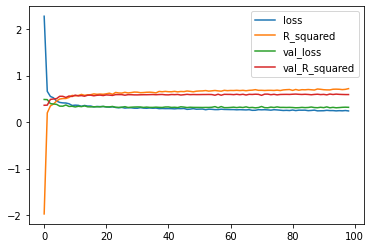

In [0]:
pd.DataFrame(history.history).plot()

## Performance

In [0]:
import tf_r2

importlib.reload(tf_r2)

DNN_r2 = dict(
    Train=tf_r2.R_squared(
        y_train, model.predict(X_train_scaled).flatten()
        ).numpy(),
    Test=tf_r2.R_squared(
        y_test, model.predict(X_test_scaled).flatten()
        ).numpy()
    )

pd.DataFrame([OLS_r2, DNN_r2], index=['OLS R2', 'DNN R2'])

Train      Test
OLS R2  0.601956  0.540067
DNN R2  0.741656  0.614756

## Map overpricing

In [0]:
dnn_predicted = model.predict(scaler.transform(fix_reviews)).flatten()
overpriced = targets-dnn_predicted
mapairbnb.plot(data, features, color_by=overpriced, color_title='Diff log price')

## Location, location, location, again!



In [0]:
location_predicted = model.predict(scaler.transform(location_only)).flatten()

mapairbnb.plot(data, features, color_by=np.exp(location_predicted),
               color_title='Predicted price', zoom=8, hover=False)

Still a faliure but at least it's not linear anymore.

# Insight from gradients

In [0]:
import tensorflow as tf

X = tf.Variable(features.values, dtype='float32')

with tf.GradientTape() as tape:
    X_std = (X-scaler.mean_) / scaler.scale_
    predictions = model(X_std)

dnn_coefs = tape.gradient(predictions, X).numpy()

dnn_coefs = pd.DataFrame(dnn_coefs,
                         columns=features.columns,
                         index=features.index)
dnn_coefs.head()

latitude  longitude  ...  Entire home/apt  Shared room
0 -0.793367  -0.349240  ...         0.444418     0.054117
1  0.140347   0.154695  ...         0.451902    -0.321407
2  0.193504   0.259178  ...         0.385948    -0.487120
3  1.904838  -0.044977  ...         0.639618    -0.415959
7  1.326335  -0.052237  ...         0.540788     0.105974

[5 rows x 15 columns]

## Compare with OLS

In [0]:
ols_coef = pd.Series(results.params[1::], name='OLS_coef')

dnn_mean_coef = pd.Series(dnn_coefs.mean(axis=0),
                          index=features.columns,
                          name='DNN_mean_grad')

pd.DataFrame([ols_coef, dnn_mean_coef]).transpose()

OLS_coef  DNN_mean_grad
latitude                       -0.135648      -0.136250
longitude                       0.058068       0.043409
accommodates                    0.046694       0.042589
bathrooms                       0.195347       0.149650
bedrooms                        0.112668       0.057399
beds                           -0.022113       0.050312
minimum_nights                 -0.005416      -0.012440
days_since_last_review          0.000704       0.000502
number_of_reviews              -0.000174      -0.002827
reviews_per_month              -0.068020      -0.118869
calculated_host_listings_count  0.002911      -0.004565
availability_30                 0.013167       0.007879
availability_365               -0.000052       0.000417
Entire home/apt                 0.768210       0.566989
Shared room                    -0.516085      -0.272893

## Variable Importance

For each observation we can estimate the importance of each variable by multiplying the coefficients by the deviation of inputs from their mean.

In [0]:
# Approximate each variable's effect by multiplying its absolute deviation from
# its mean by the sensitivity of prediction to that variable.
abs_effect = (dnn_coefs * (features-features.mean())).abs()

# Compute per-row sum and reshape it to a vertical vector
abs_effect_sum = np.reshape(abs_effect.sum(axis=1).values, (len(features), 1))

# Divide by the sum so that effects sum to 1
per_obs_importance = abs_effect / abs_effect_sum

per_obs_importance.head()

latitude  longitude  ...  Entire home/apt  Shared room
0  0.041580   0.015869  ...         0.300052     0.001133
1  0.007758   0.023625  ...         0.450579     0.005344
2  0.022108   0.012810  ...         0.455636     0.009590
3  0.072668   0.002605  ...         0.139472     0.002812
7  0.055412   0.001044  ...         0.243436     0.000795

[5 rows x 15 columns]

Averaging across observations we have a measure of variable importance.

In [0]:
mean_abs_effect = per_obs_importance.mean().sort_values(ascending=False)

pd.DataFrame(
    mean_abs_effect/mean_abs_effect.sum(),
    columns=['Variable Importance'])

Variable Importance
Entire home/apt                            0.217001
reviews_per_month                          0.107592
accommodates                               0.094127
bathrooms                                  0.070460
number_of_reviews                          0.068079
availability_30                            0.065226
bedrooms                                   0.061742
beds                                       0.059613
availability_365                           0.053656
days_since_last_review                     0.045405
calculated_host_listings_count             0.044446
latitude                                   0.044318
longitude                                  0.040854
minimum_nights                             0.018799
Shared room                                0.008681

## Error analysis

In [0]:
%%writefile erranalysis.py

import pandas as pd
import numpy as np


def table(predictions, targets, features, data, per_obs_importance, dnn_coefs,
          mean_abs_effect):

    pred = pd.Series(predictions.numpy().flatten(),
                     index=features.index,
                     name='pred')

    err = (pred - targets).sort_values()
    err.name = 'log pred - log price'

    error_analysis = (
        features.loc[err.index]
        .join(per_obs_importance.loc[err.index], rsuffix='_importance')
        .join(dnn_coefs.loc[err.index], rsuffix='_coef')
        )

    col = []
    for index in mean_abs_effect.index:
        col.append(index + '_importance')
        col.append(index + '_coef')
        col.append(index)
    col

    error_analysis = error_analysis.reindex(col, axis=1)
    error_analysis = (
        pd.DataFrame(data.name[err.index])
        .join('<a href="' + data.listing_url[err.index] + '">link</a>')
        .join(pred[err.index].apply(np.exp))
        .join(targets[err.index].apply(np.exp))
        .join(error_analysis)
        )

    return error_analysis


Writing erranalysis.py


In [0]:
from IPython.display import HTML
import erranalysis

importlib.reload(erranalysis)

error_analysis = erranalysis.table(
    predictions, targets, features, data, per_obs_importance, dnn_coefs,
    mean_abs_effect)

HTML(error_analysis.head().to_html(escape=False))

In [0]:
HTML(error_analysis.tail().to_html(escape=False))

## Explore non-linearity

In [0]:
%%writefile plotcoefs.py
import matplotlib.pyplot as plt


def plot_coefs_by_self(features, coefs, ols_results):

    plt.style.use('seaborn-whitegrid')

    for i, field in enumerate(features.columns):

        plt.scatter(
            x=features[field],
            y=coefs[field],
            alpha=0.05)

        plt.plot([features.min()[field], features.max()[field]],
                 [0, 0], '--', color='grey')

        # OLS coef
        plt.plot([features.min()[field], features.max()[field]],
                 [ols_results.params[field], ols_results.params[field]],
                 ':',
                 color='black'
                 )

        # OLS confidence intervals
        plt.fill_between(
            [features.min()[field], features.max()[field]],
            [ols_results.conf_int().loc[field, 0],
             ols_results.conf_int().loc[field, 0]],
            [ols_results.conf_int().loc[field, 1],
             ols_results.conf_int().loc[field, 1]],
            color='gray', alpha=0.2)

        plt.xlabel(field)
        plt.ylabel(field + ' coef')
        plt.legend(['Zero', 'OLS coef'])
        plt.show()


Writing plotcoefs.py


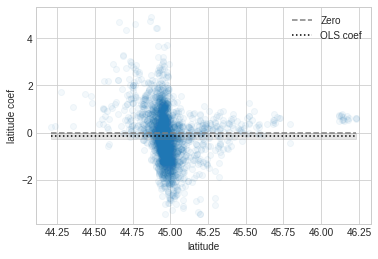

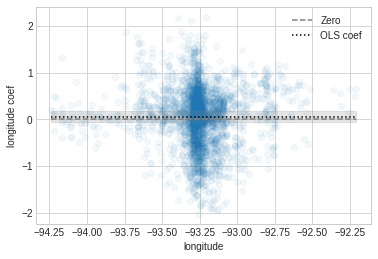

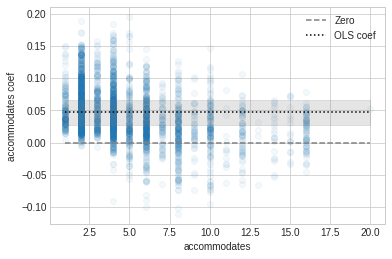

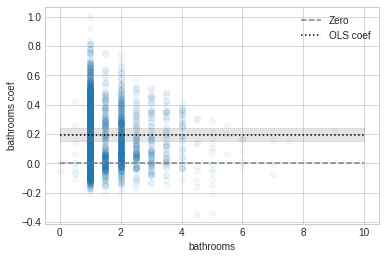

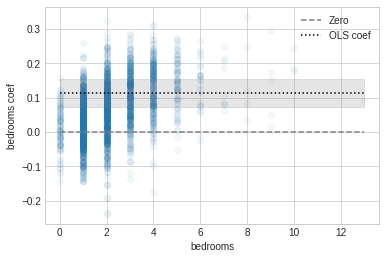

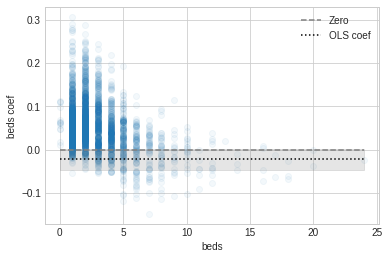

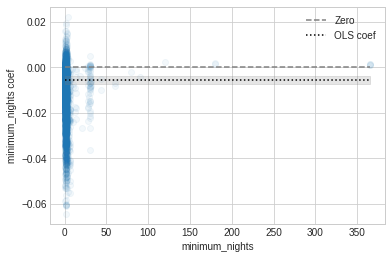

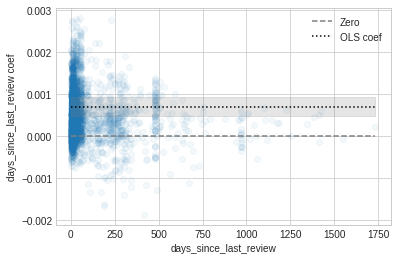

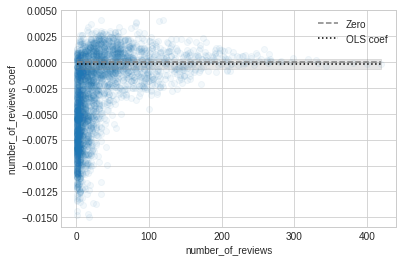

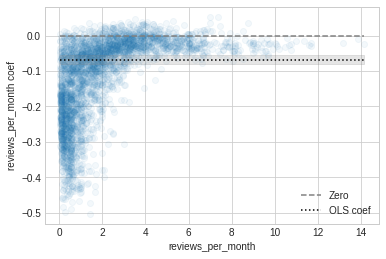

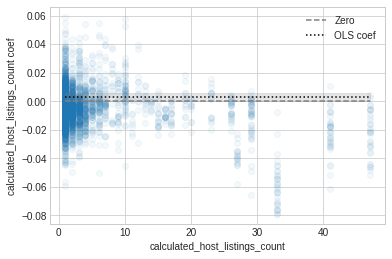

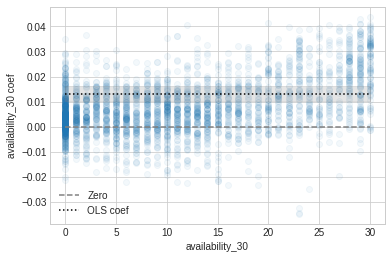

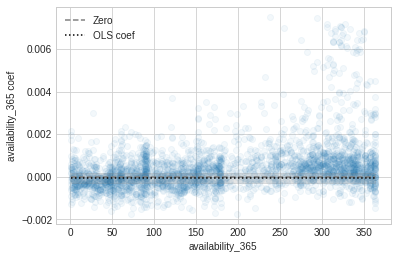

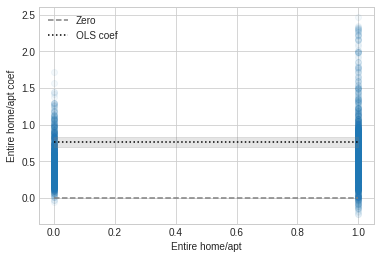

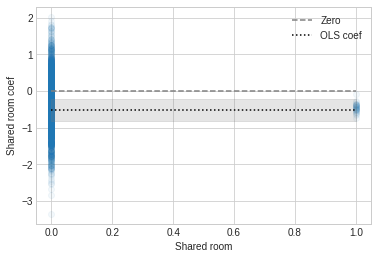

In [0]:
import plotcoefs

importlib.reload(plotcoefs)

plotcoefs.plot_coefs_by_self(features, dnn_coefs, results)

## Location gradiants

If we think location coefficients as a 2-dimensional vector then its norm is a measure of effect of location on price.

In [0]:
location_sensitivity = dnn_coefs[['latitude', 'longitude']].apply(
    np.linalg.norm, axis=1)

mapairbnb.plot(data, features, color_by=location_sensitivity,
               color_title='location sensitivity', hover=False)

We see listings that are very sensitive mixed among ones that are not. So location sensitivity must be driven by features other than location itself. 

In [0]:
location_sensitivity.name = 'loc_sens'
with_loc_sens = features.join(location_sensitivity).sort_values(by='loc_sens')

# Pick a few listings from the high end of the sensitivity sort
# and use them to get a location valuation plot
for p in np.linspace(0.9, 1, 5):

    i = int(p * (len(features)-1))

    fixed_app = with_loc_sens.iloc[i, :].drop('loc_sens')
    print(with_loc_sens.iloc[i, :].drop(['latitude', 'longitude']))

    location_only = fixcolumns.fix(data=features,
                                   fix_columns=features.columns[2:],
                                   fix_on=fixed_app.values)

    location_predicted = model.predict(
        scaler.transform(location_only)).flatten()

    mapairbnb.plot(data, features, color_by=np.exp(location_predicted),
                   color_title='Predicted price', hover=False, zoom=8).show()

accommodates                       4.000000
bathrooms                          1.000000
bedrooms                           2.000000
beds                               2.000000
minimum_nights                     3.000000
days_since_last_review            20.000000
number_of_reviews                 45.000000
reviews_per_month                  2.800000
calculated_host_listings_count     1.000000
availability_30                    9.000000
availability_365                  20.000000
Entire home/apt                    1.000000
Shared room                        0.000000
loc_sens                           1.856922
Name: 4636, dtype: float64


accommodates                       16.000000
bathrooms                           7.000000
bedrooms                            8.000000
beds                                9.000000
minimum_nights                      2.000000
days_since_last_review            196.000000
number_of_reviews                  21.000000
reviews_per_month                   0.640000
calculated_host_listings_count      1.000000
availability_30                    17.000000
availability_365                  322.000000
Entire home/apt                     1.000000
Shared room                         0.000000
loc_sens                            2.010326
Name: 747, dtype: float64


accommodates                       10.000000
bathrooms                           2.000000
bedrooms                            2.000000
beds                                3.000000
minimum_nights                      1.000000
days_since_last_review             91.000000
number_of_reviews                  23.000000
reviews_per_month                   1.470000
calculated_host_listings_count      1.000000
availability_30                     0.000000
availability_365                  145.000000
Entire home/apt                     1.000000
Shared room                         0.000000
loc_sens                            2.225085
Name: 4275, dtype: float64


accommodates                       11.000000
bathrooms                           2.000000
bedrooms                            5.000000
beds                                6.000000
minimum_nights                      2.000000
days_since_last_review              7.000000
number_of_reviews                  18.000000
reviews_per_month                   0.710000
calculated_host_listings_count      2.000000
availability_30                    24.000000
availability_365                  324.000000
Entire home/apt                     1.000000
Shared room                         0.000000
loc_sens                            2.719373
Name: 1575, dtype: float64


accommodates                       4.000000
bathrooms                          2.000000
bedrooms                           2.000000
beds                               3.000000
minimum_nights                     2.000000
days_since_last_review            14.000000
number_of_reviews                  3.000000
reviews_per_month                  0.510000
calculated_host_listings_count     2.000000
availability_30                    0.000000
availability_365                  93.000000
Entire home/apt                    1.000000
Shared room                        0.000000
loc_sens                           5.112391
Name: 5791, dtype: float64


Maps for high location sensitivity listings are generally better. Can we do any better still?

# Finally: location!
 

Let's build a model where location is not allowed to interact with anything else.

In [0]:
%%writefile loc_dnn.py
import tensorflow.keras as keras
from tf_r2 import R_squared


def build_model(
        input_shape,
        dropout=0.2,
        activation='relu',
        width=128,
        n_hidden=2,
        optimizer=keras.optimizers.SGD(0.05)):

    inputs = keras.Input(shape=input_shape)

    # Seperate the location on the first two indexes from the rest of
    # the inputs.
    loc = inputs[:, :2]
    for i in range(n_hidden):
        loc = keras.layers.Dense(width, activation=activation)(loc)
        loc = keras.layers.Dropout(dropout)(loc)
    loc = keras.layers.Dense(1)(loc)

    rest = inputs[:, 2:]
    for i in range(n_hidden):
        rest = keras.layers.Dense(width, activation=activation)(rest)
        rest = keras.layers.Dropout(dropout)(rest)
    rest = keras.layers.Dense(1)(rest)

    # Sum the two outputs so that they both have log price units.
    output = loc + rest

    loc_model = keras.Model(inputs=inputs, outputs=loc)
    full_model = keras.Model(inputs=inputs, outputs=output)

    full_model.compile(loss='mse',
                       optimizer=optimizer,
                       metrics=[R_squared])

    return full_model, loc_model


Writing loc_dnn.py


In [0]:
import loc_dnn

importlib.reload(loc_dnn)

model_all, loc_model = loc_dnn.build_model(X_train.shape[1:])

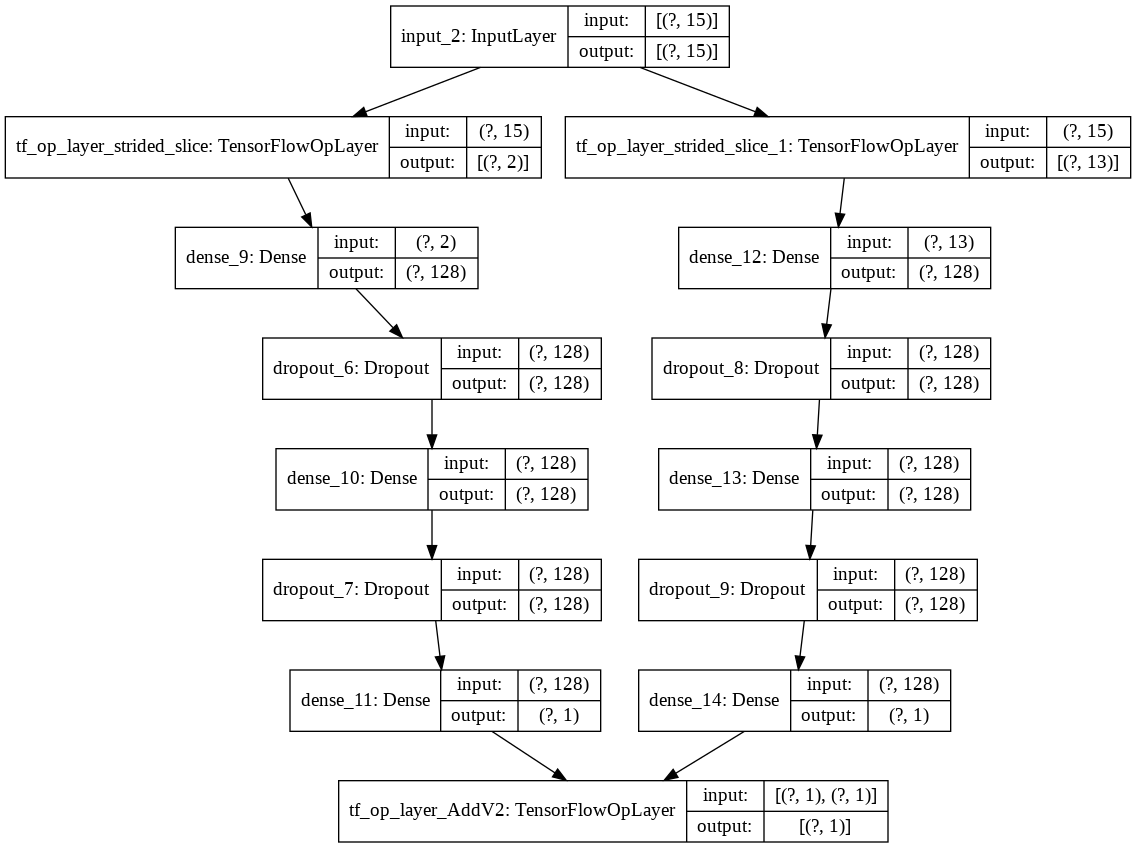

In [0]:
import tensorflow.keras as keras

keras.utils.plot_model(model_all, show_shapes=True)

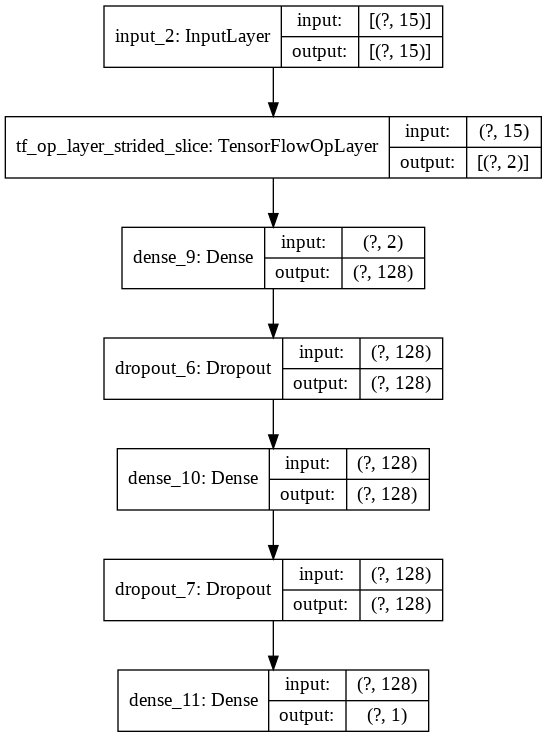

In [0]:
keras.utils.plot_model(loc_model, show_shapes=True)

In [0]:
history = simple_dnn.train_model(
    model_all,
    X_train_scaled, y_train, 
    X_test_scaled, y_test)

Epoch 1/1000
69/69 [==============================] - 0s 4ms/step - loss: 1.3001 - R_squared: -0.5199 - val_loss: 0.3706 - val_R_squared: 0.5149
Epoch 2/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.4235 - R_squared: 0.4860 - val_loss: 0.3539 - val_R_squared: 0.5431
Epoch 3/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.3904 - R_squared: 0.5400 - val_loss: 0.3296 - val_R_squared: 0.5733
Epoch 4/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.3708 - R_squared: 0.5573 - val_loss: 0.3393 - val_R_squared: 0.5695
Epoch 5/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.3641 - R_squared: 0.5605 - val_loss: 0.3150 - val_R_squared: 0.5969
Epoch 6/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.3462 - R_squared: 0.5902 - val_loss: 0.3105 - val_R_squared: 0.6038
Epoch 7/1000
69/69 [==============================] - 0s 2ms/step - loss: 0.3340 - R_squared: 0.6011 - val_loss: 0.3158 - val_R_squared

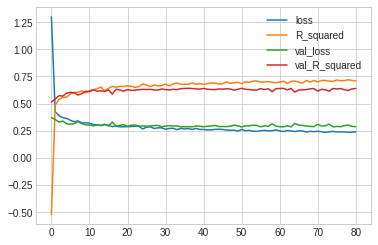

In [0]:
pd.DataFrame(history.history).plot()

In [0]:
import tf_r2

importlib.reload(tf_r2)

loc_DNN_r2 = dict(
    Train=tf_r2.R_squared(
        y_train, model_all.predict(X_train_scaled).flatten()).numpy(),
    Test=tf_r2.R_squared(
        y_test, model_all.predict(X_test_scaled).flatten()).numpy())

pd.DataFrame([OLS_r2, DNN_r2, loc_DNN_r2], index=['OLS R2', 'DNN R2', 'loc DNN R2'])

Train      Test
OLS R2      0.601956  0.540067
DNN R2      0.741656  0.614756
loc DNN R2  0.741126  0.643012

In [0]:
location_predicted = loc_model.predict(scaler.transform(features)).flatten()

mapairbnb.plot(data, features, color_by=location_predicted,
               color_title='Diff log price', hover=False, zoom=8)